In [1]:
#  Required imports
print("Importing standard library")
import os, time, sys

print("Importing python data libraries")
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

print("Importing custom backends")
from   backends.stats import special_whiten_dataset, special_unwhiten_dataset, whiten_data, unwhiten_data
from   backends.utils import joint_shuffle, make_sure_dir_exists_for_filename
from   backends.ParameterisedSimulator import ParameterisedSimulator, Simulator_Model3
from   backends.SamplingSimulator      import SamplingSimulator

print("Importing keras objects")
from keras.layers      import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda, Reshape, Softmax
from keras.models      import Model, Sequential
from keras.optimizers  import Adam, SGD, RMSprop
from keras.constraints import Constraint, MaxNorm
from keras.callbacks   import EarlyStopping

print("Importing keras backend")
import keras.backend as K

Importing standard library
Importing python data libraries
Importing custom backends
Importing keras objects
Importing keras backend


Using TensorFlow backend.


In [40]:
#  Program constants

mu_scan_points = np.linspace(-2, 3, 11)

n_true_points_per_c_per_ds = 50000
n_fake_points_per_c_per_ds = 50000
output_size_per_stage     = 10
max_epochs                = 1000
early_stopping_patience   = 100

do_whiten_data = True
white_linear_fraction_data  = 0.5
white_linear_fraction_gauss = 0.5

plot_tag = None

axis_lims = [(50, 250), (50, 500), (-1*np.pi, np.pi)]
if do_whiten_data : axis_lims = [(-5., 5.), (-5., 5.), (-5., 5.)]

In [3]:
#  Set up "true" model
model = Simulator_Model3

#  Generate several scan points for "true" model
xsections, datasets, weights = {}, {}, {}
for mu in mu_scan_points :
    model.set_param_value("c", mu)
    xsec, dataset = model.generate(n_true_points_per_c_per_ds)
    xsections [mu] = xsec
    datasets  [mu] = dataset
    weights   [mu] = np.full(shape=(len(dataset),), fill_value=1./n_true_points_per_c_per_ds)
    
#  Make sure one of the datasets was the SM
model.set_param_value("c", 0)
if 0 not in xsections :
    xsections [0], datasets [0] = model.generate(n_true_points_per_c_per_ds)
    mu_scan_points = np.sort(np.concatenate([mu_scan_points, [0]]))
    weights [0] = np.full(shape=(len(dataset),), fill_value=1./n_true_points_per_c_per_ds)
xsec_SM, dataset_SM, weights_SM = xsections[0], datasets[0], weights[0]

#  Whiten the data using the "special" hard-boundary-respecting method
if do_whiten_data :
    white_dataset_SM, whitening_funcs, whitening_params = special_whiten_dataset (dataset_SM,
                                                                                  [50, 250, 201, white_linear_fraction_data, white_linear_fraction_gauss],
                                                                                  [50, 500, 301, white_linear_fraction_data, white_linear_fraction_gauss],
                                                                                  [-1.*np.pi, np.pi, 101, white_linear_fraction_data, white_linear_fraction_gauss],
                                                                                  rotate=False)
else :
    white_dataset_SM, whitening_funcs, whitening_params = dataset_SM, None, None

def whiten_data (dataset) :
    if do_whiten_data == False : return dataset
    white_datasets = {}
    for mu in dataset :
        white_datasets [mu], _, _ = special_whiten_dataset (dataset[mu], 
                                                            whitening_funcs =whitening_funcs, 
                                                            whitening_params=whitening_params,
                                                            rotate=False)
    return white_datasets

def unwhiten_data (dataset) : 
    if do_whiten_data == False : return dataset 
    unwhite_datasets = {}
    for mu in dataset :
        unwhite_datasets [mu] = special_unwhiten_dataset (dataset[mu], 
                                                          whitening_funcs =whitening_funcs, 
                                                          whitening_params=whitening_params)
    return unwhite_datasets
        
white_datasets   = whiten_data  (datasets      )
unwhite_datasets = unwhiten_data(white_datasets)
num_datasets = len(white_datasets)
print(f"Datasets generated for scan points: {', '.join([f'{mu:.3f}' for mu in mu_scan_points])}")

Datasets generated for scan points: -2.000, -1.500, -1.000, -0.500, 0.000, 0.500, 1.000, 1.500, 2.000, 2.500, 3.000


In [4]:
def plot_dataset (mu_scan_points, xsections, datasets, weights=None, ref=None) :
    num_datasets = len(mu_scan_points)
           
    if type(weights) == type(None) :
        tmp_weights = {mu:np.full(fill_value=1./len(datasets[mu]), shape=(len(datasets[mu]),)) for mu in mu_scan_points}
    elif type(weights) == np.ndarray :
        tmp_weights = {mu:weights/np.sum(weights) for mu in mu_scan_points}
    elif type(weights) == dict : 
        tmp_weights = {mu:tmp_weights/np.sum(tmp_weights) for mu, tmp_weights in weights.items()}
    else :
        raise TypeError(f"Don't know what to do with weights of type {type(weights)}")
    
    plot_reference = False
    if type(ref) != type(None) :
        plot_reference = True
        xsections_ref, datasets_ref, weights_ref = ref
        
        if type(datasets_ref) == np.ndarray :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        elif type(datasets_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            raise TypeError(f"Don't know what to do with reference dataset of type {type(datasets_ref)}")
            
        if type(weights_ref) == type(None) :
            tmp_weights_ref = {mu:np.full(fill_value=1/len(tmp_datasets_ref[mu]), shape=(len(tmp_datasets_ref[mu]),)) for mu in mu_scan_points}
        elif type(weights_ref) == np.ndarray :
            tmp_weights_ref = {mu:weights_ref/np.sum(weights_ref) for mu in mu_scan_points}
        elif type(weights_ref) == dict : 
            tmp_weights_ref = {mu:tmp_weights_ref/np.sum(tmp_weights_ref) for mu, tmp_weights_ref in weights_ref.items()}
        else :
            raise TypeError(f"Don't know what to do with reference weights of type {type(weights_ref)}")
            
        if type(xsections_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        
        if type(xsections_ref) == type(None) :
            raise RuntimeError(f"Reference datasets must be provided reference cross sections too")
        if type(datasets_ref) == dict : 
            tmp_xsections_ref = xsections_ref
        else :
            tmp_xsections_ref = {mu:xsections_ref for mu in mu_scan_points}

    num_plot_rows = 6
    if plot_reference : num_plot_rows = 9
    
    fig = plt.figure(figsize=(4*num_datasets, 4*num_plot_rows))
    plot_row_idx = 0
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,0], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-", linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,0], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        ax1.set_title(f"$c = {mu:.3f}$", fontsize=30)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dA}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,1], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,1], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dB}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,2], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,2], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dC}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $B$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $B$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$B$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$B$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")
                
    plt.show()


Plotting datasets


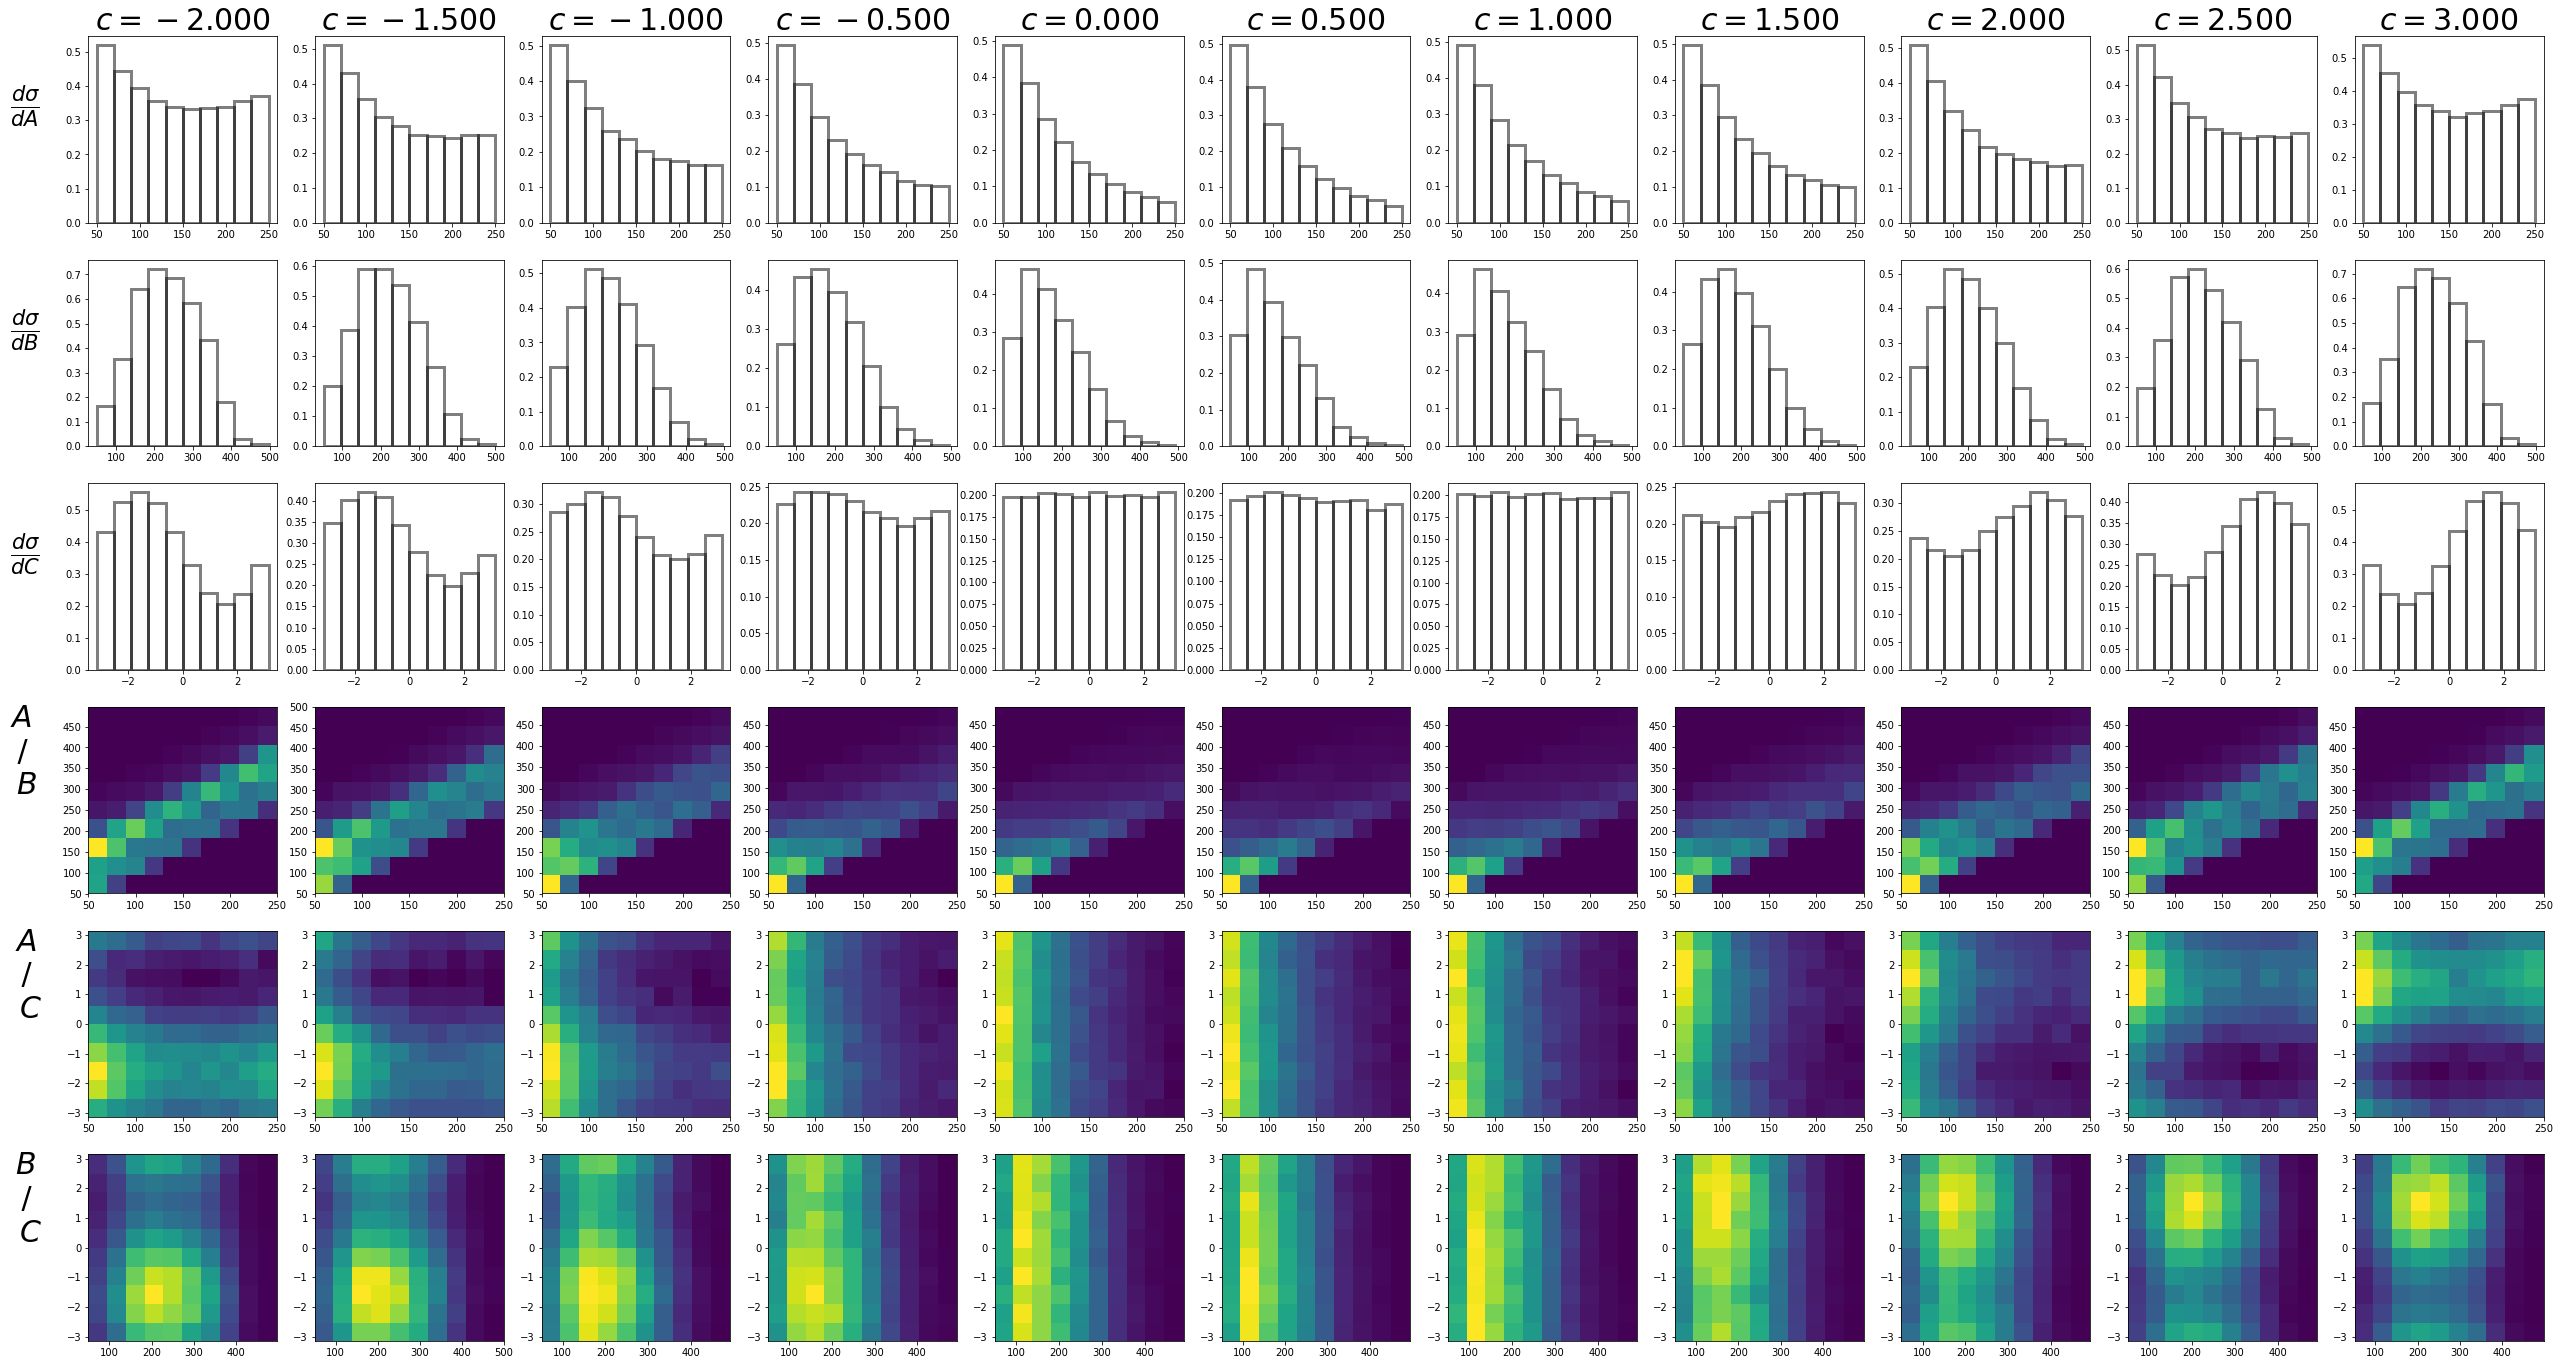

Plotting unwhitened(whitened(datasets)) to show this reconstructs original datasets


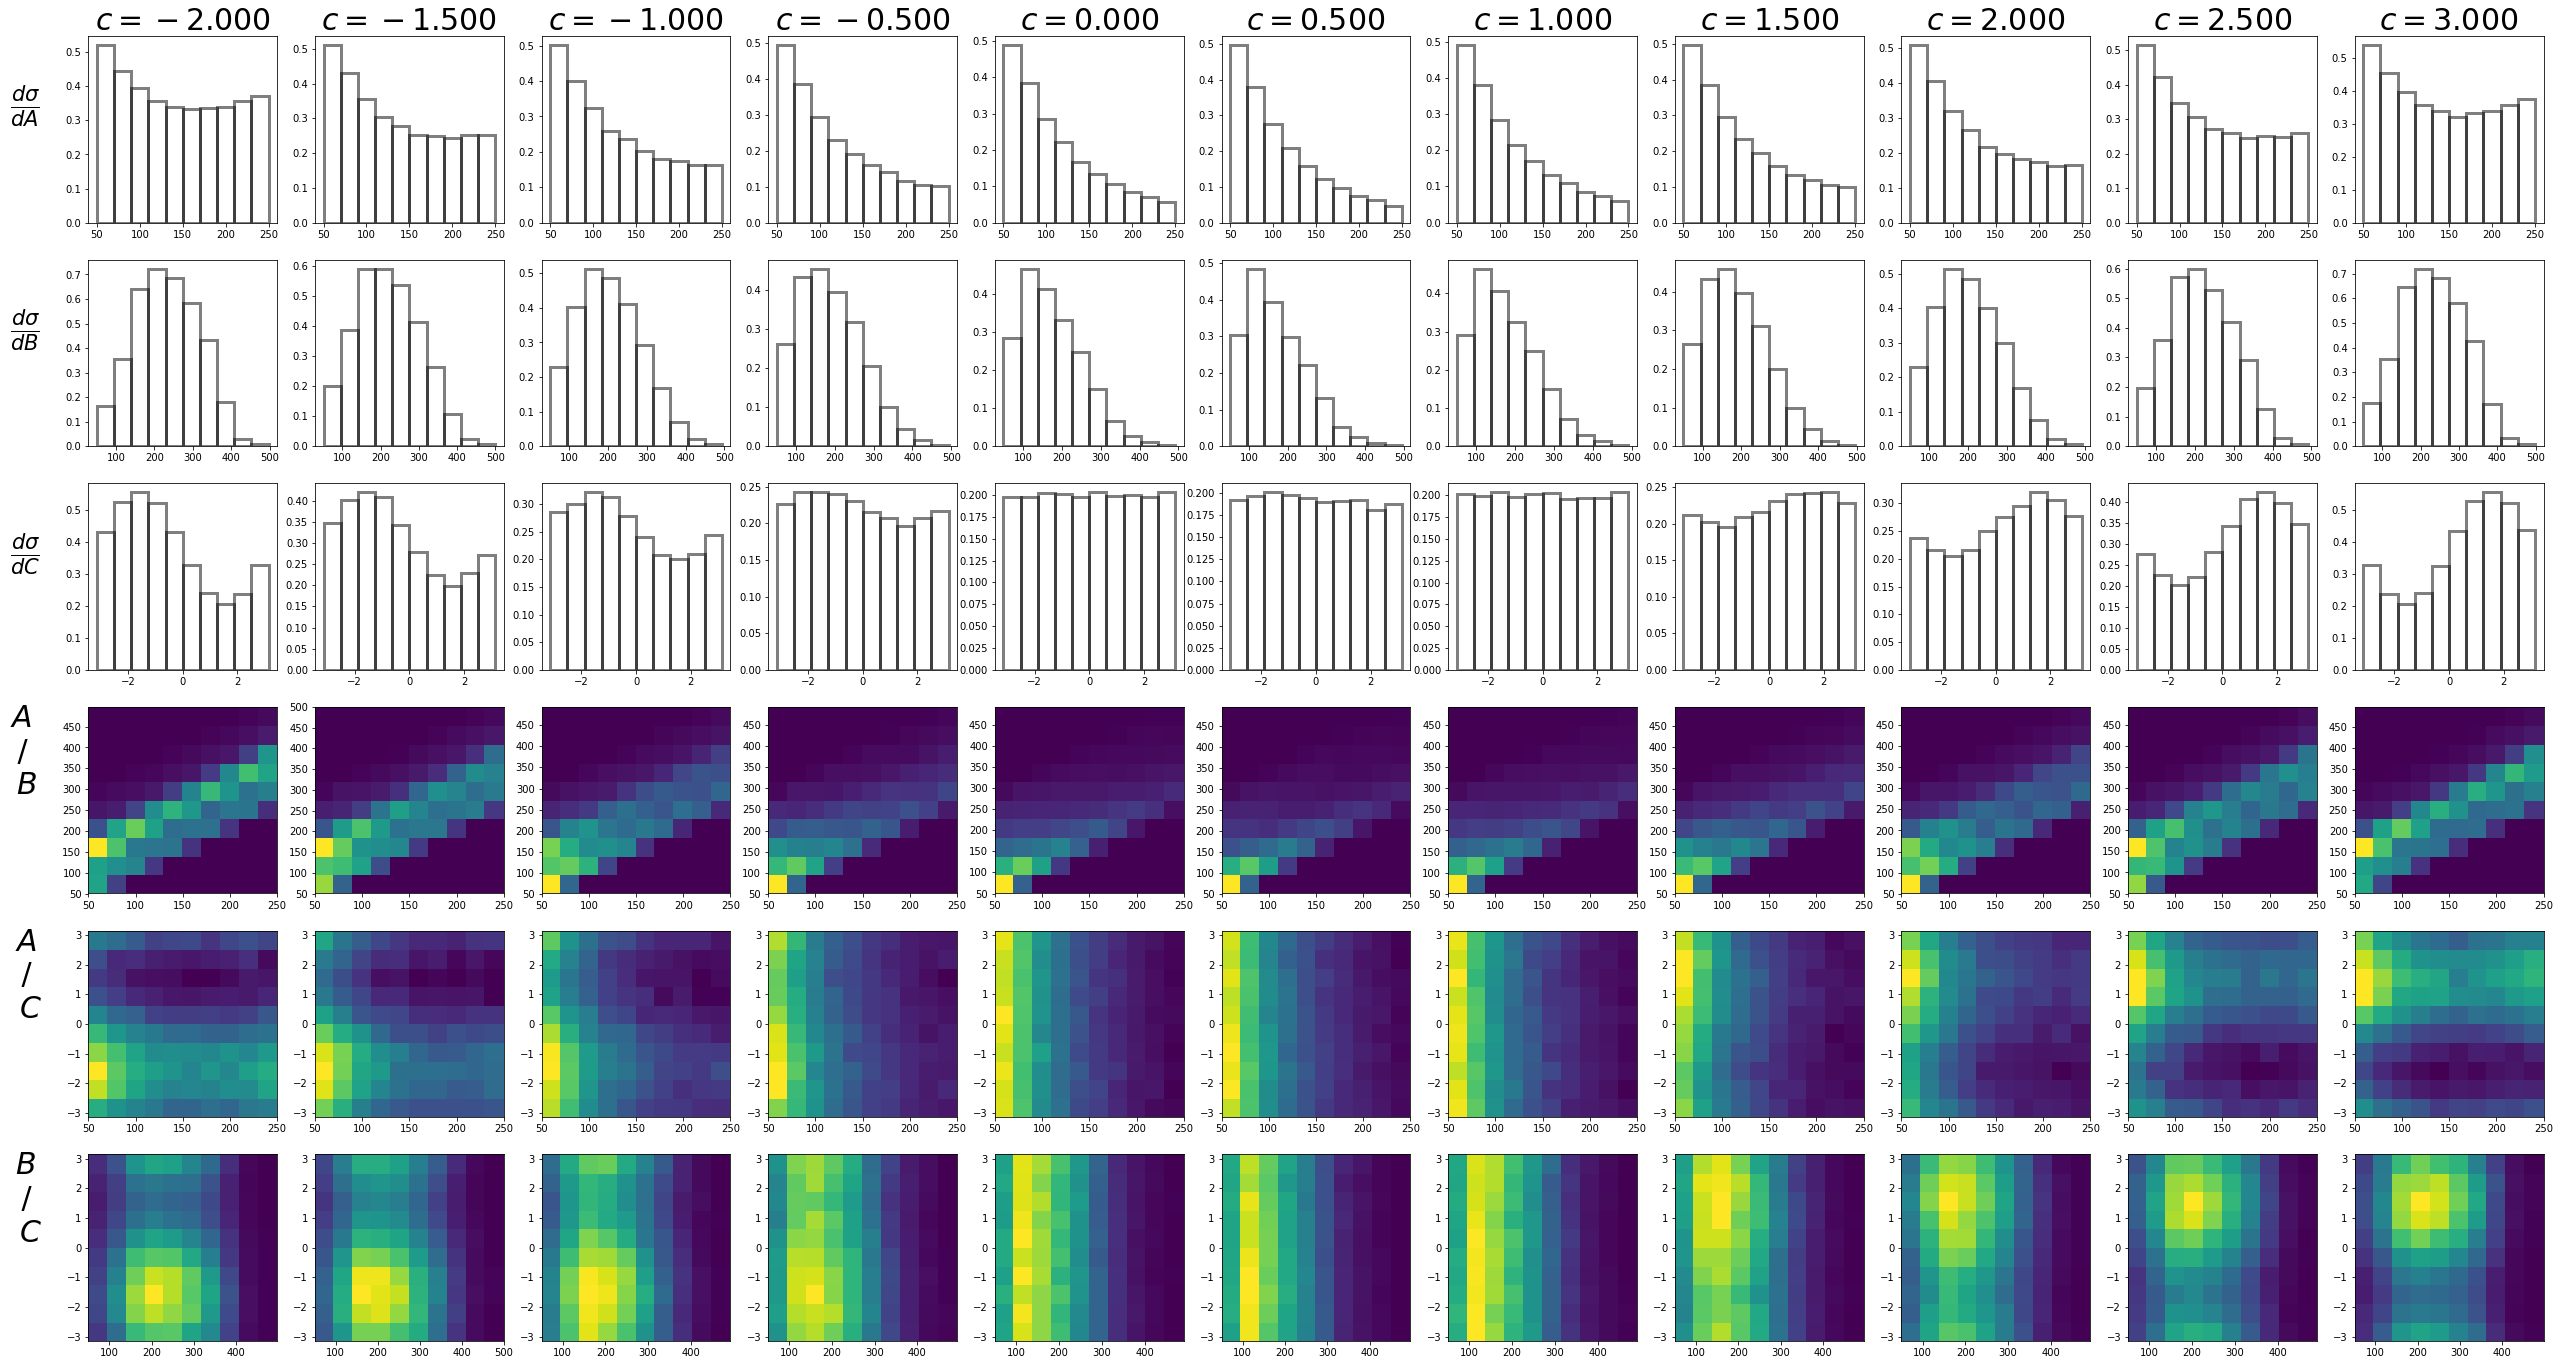

In [5]:
print("Plotting datasets")
#plot_dataset(mu_scan_points, xsections, datasets, weights, ref=(xsec_SM, dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, datasets, weights)

print("Plotting unwhitened(whitened(datasets)) to show this reconstructs original datasets")
#plot_dataset(mu_scan_points, xsections, unwhiten_data(white_datasets), weights, ref=(xsec_SM, dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, unwhiten_data(white_datasets), weights)



Plotting whitened datasets


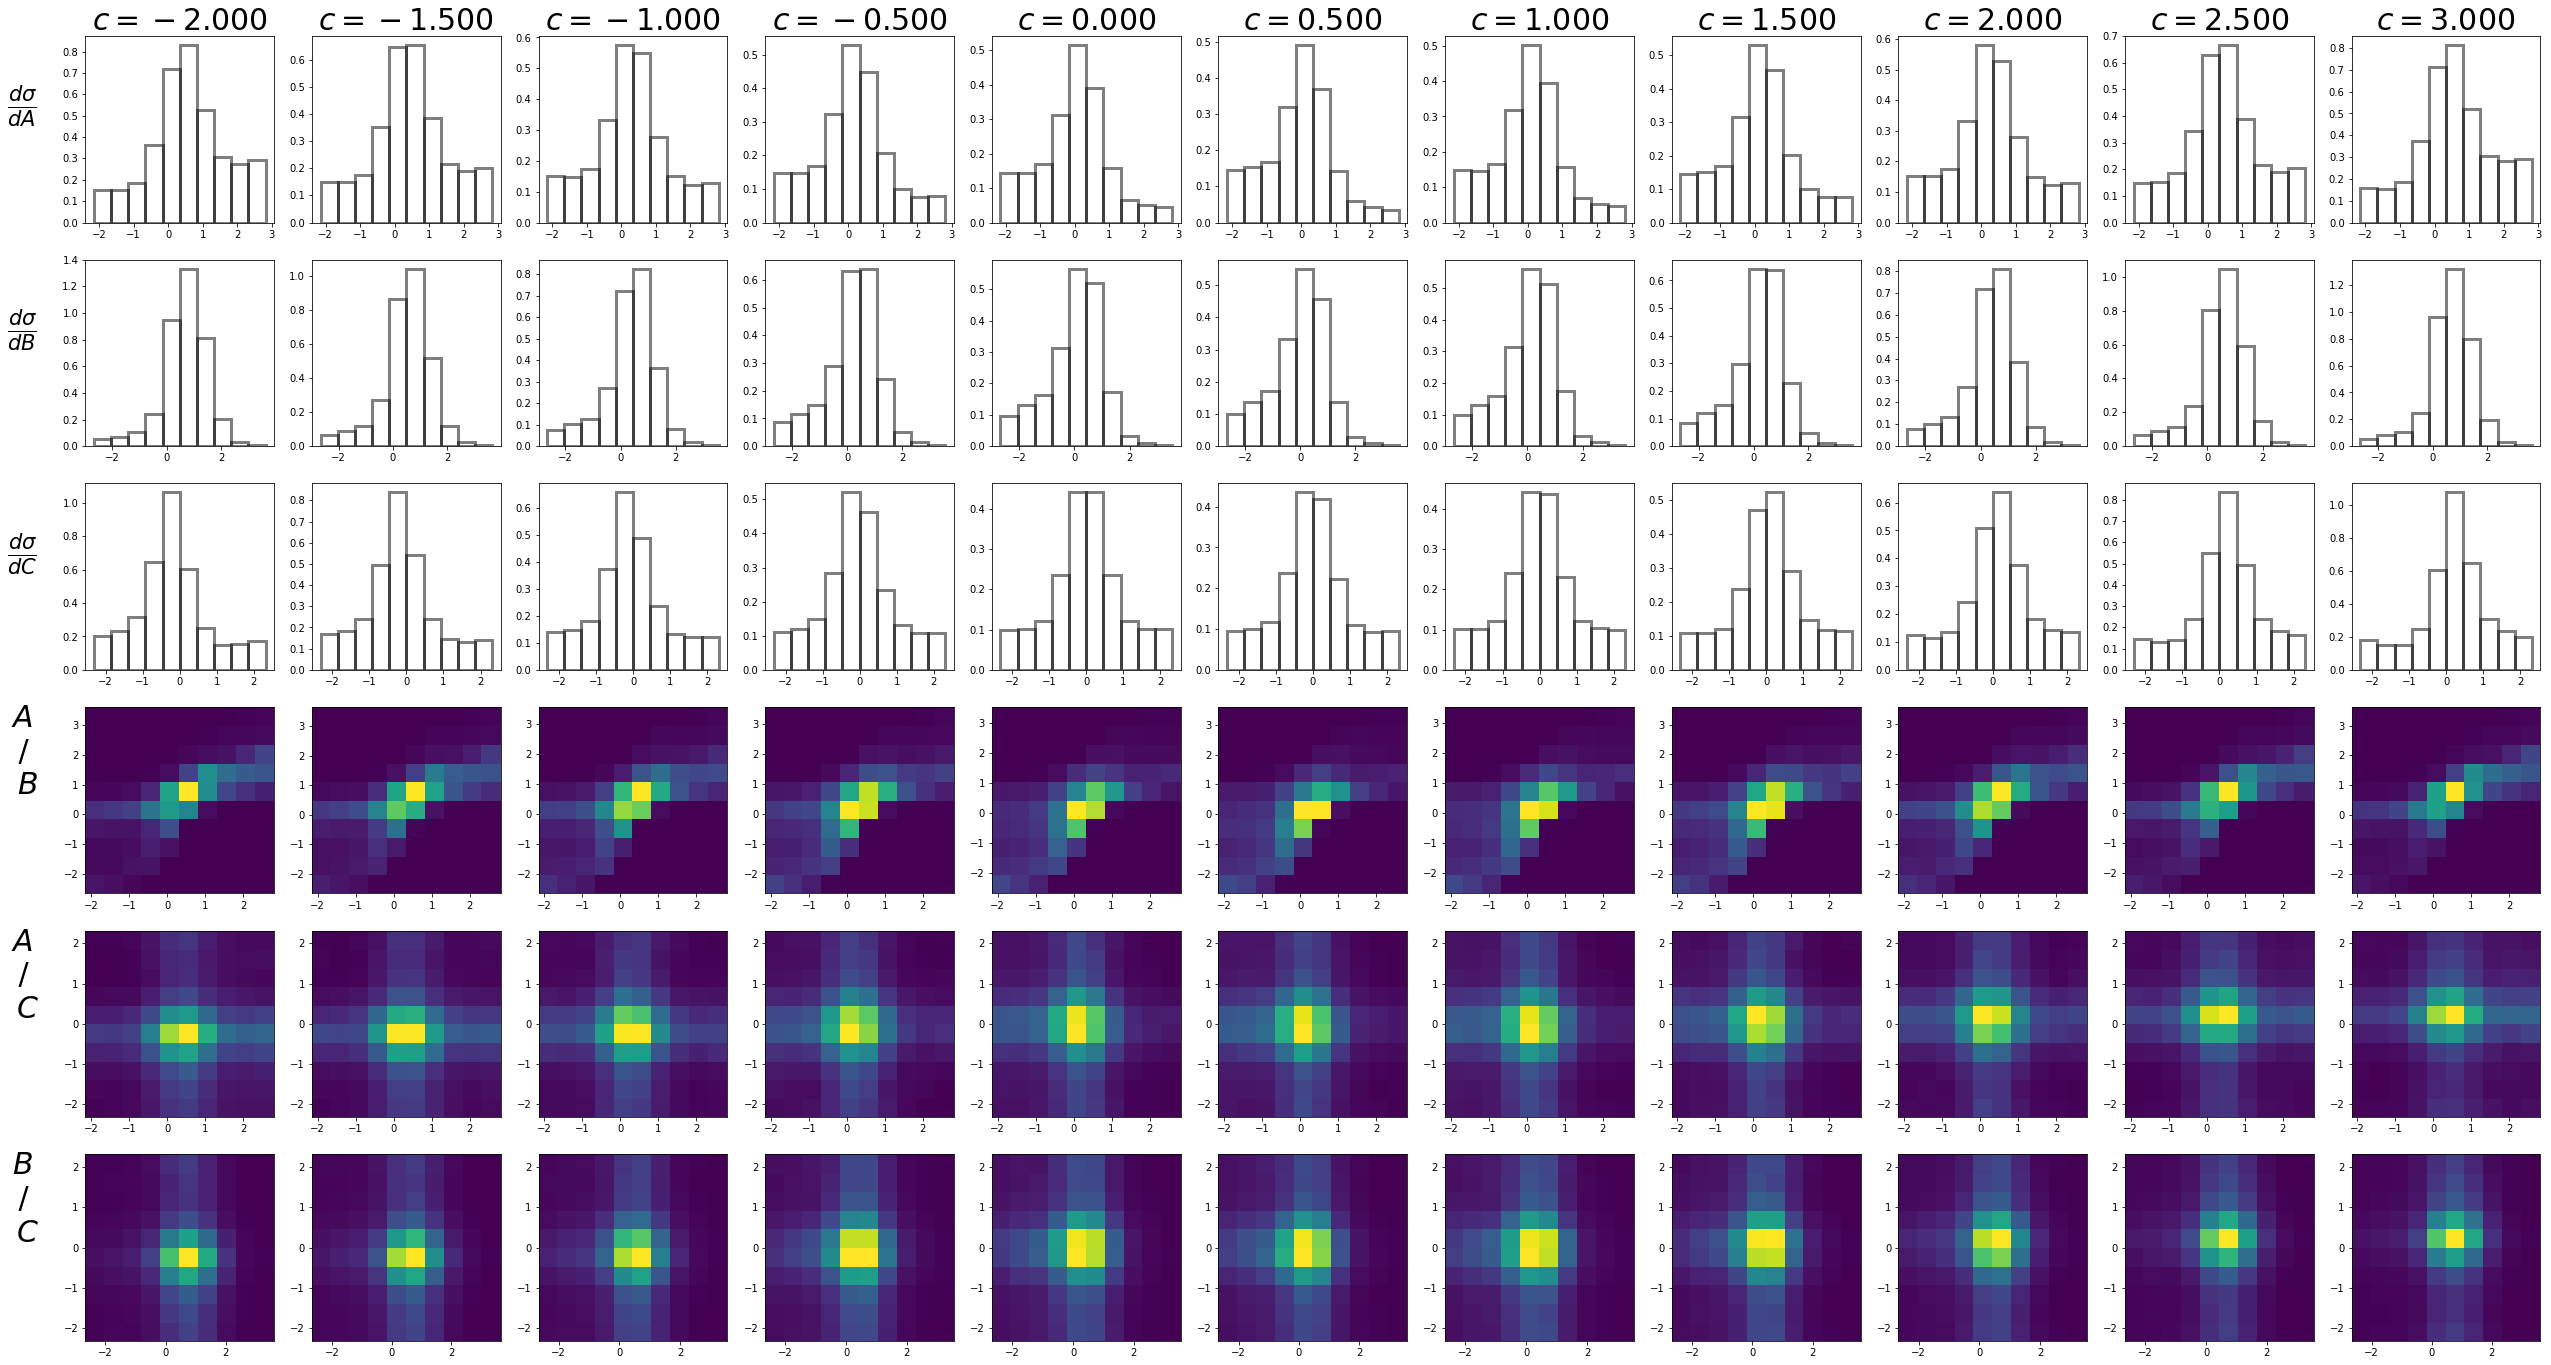

In [6]:
print("Plotting whitened datasets")
#plot_dataset(mu_scan_points, xsections, white_datasets, weights, ref=(xsec_SM, white_dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, white_datasets, weights)

In [7]:
def gauss_prob (x, mean, sigma) :
    prob = K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)
    return tf.where(tf.is_nan(prob), tf.zeros_like(prob), prob)


def datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob


def datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    log_L = K.log(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
    return  log_L  # tf.where(tf.is_nan(log_L), -1e-12*tf.ones_like(log_L), log_L)


def dataset_mean_likelihood  (x, params, num_gauss) :
    return K.mean(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))  


def dataset_likelihood (x, params, num_gauss) :
    prod_L = K.prod(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))  
    return tf.where(tf.is_nan(prod_L), tf.zeros_like(prod_L), prod_L)
        

def dataset_mean_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K.mean(datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))    
    
    
def add_gauss_mean_offsets (x, num_gauss, offset_min, offset_max):
    c = tf.convert_to_tensor([offset_min + (offset_max-offset_min)*i/(num_gauss-1.) for i in range(num_gauss)])
    return x + c


def add_gauss_fraction_offsets (x, num_gauss):
    c = tf.convert_to_tensor([0. for i in range(num_gauss)])
    return x + c


def add_gauss_sigma_offsets (x, num_gauss):
    c = tf.convert_to_tensor([0. for i in range(num_gauss)])
    return x + c


def create_autoreg_density_model (name, **kwargs) :
    #  Parse arguments
    #
    num_conditions_in  = int (kwargs.get("num_conditions_in"    ))
    num_observables_in = int (kwargs.get("num_observables_in", 0))
    num_gaussians      = int (kwargs.get("num_gaussians"     , 5))
    verbose            = bool(kwargs.get("verbose" , True))
    
    #  Print a status message
    #
    if verbose : 
        print(f"Creating density model: {name}")
        print(f"  - num_conditions_in  is {num_conditions_in}")
        print(f"  - num_observables_in is {num_observables_in}")
        print(f"  - num_gaussians      is {num_gaussians}")
    
    #  Create model
    #
    conditions_input  = Input((num_conditions_in ,))
    model_conditions  = Dense      (10 )(conditions_input ) 
    model_conditions  = LeakyReLU  (0.2)(model_conditions )
    '''model_conditions  = Dense      (10 )(model_conditions )
    model_conditions  = LeakyReLU  (0.2)(model_conditions )''' 
    if num_observables_in > 0 :
        observables_input = Input((num_observables_in,))
        model_observables = Dense      (3*num_observables_in)(observables_input)    
        model_observables = LeakyReLU  (0.2                 )(model_observables)
        '''model_observables = Dense      (3*num_observables_in)(model_observables)    
        model_observables = LeakyReLU  (0.2                 )(model_conditions )'''
        model             = Concatenate(   )([model_conditions, model_observables])
    else :
        model = model_conditions
    #model             = Dropout    (0.1)(model)
    #model             = Dense      (10 + 2*num_gaussians + 3*num_observables_in)(model)
    #model             = Dropout    (0.1)(model)
    #model             = LeakyReLU  (0.2)(model)
    #model             = Dense      (10 + 2*num_gaussians + 3*num_observables_in)(model)
    #model             = LeakyReLU  (0.2)(model)
    gauss_means       = Dense      (3*num_gaussians )(model          )
    gauss_means       = LeakyReLU  (0.2             )(gauss_means    )
    gauss_sigmas      = Dense      (3*num_gaussians )(model          )
    gauss_sigmas      = LeakyReLU  (0.2             )(gauss_sigmas   )
    gauss_fractions   = Dense      (3*num_gaussians )(model          )
    gauss_fractions   = LeakyReLU  (0.2             )(gauss_fractions)
    
    gauss_means       = Dense (num_gaussians, activation="linear"  )(gauss_means)
    add_initial_mean_offsets = lambda x : add_gauss_mean_offsets(x, num_gaussians, -5, 5)
    gauss_means              = Lambda(add_initial_mean_offsets)(gauss_means)
    
    add_initial_sigma_offsets = lambda x : add_gauss_sigma_offsets(x, num_gaussians)
    gauss_sigmas              = Dense (num_gaussians                       )(gauss_sigmas)
    gauss_sigmas              = Lambda(add_initial_sigma_offsets           )(gauss_sigmas)
    gauss_sigmas              = Dense (num_gaussians, activation="softplus")(gauss_sigmas)
    
    add_initial_frac_offsets = lambda x : add_gauss_fraction_offsets(x, num_gaussians)
    gauss_fractions          = Dense  (num_gaussians                       )(gauss_fractions)
    gauss_fractions          = Lambda (add_initial_frac_offsets            )(gauss_fractions)
    gauss_fractions          = Softmax(                                    )(gauss_fractions)
    #gauss_fractions          = Dense (num_gaussians, activation="softmax" )(gauss_fractions)
    
    model             = Concatenate()([gauss_fractions, gauss_means, gauss_sigmas])
    if num_observables_in > 0 : model = Model ([conditions_input, observables_input], model, name=name)
    else                      : model = Model (conditions_input, model, name=name)
    
    loss_function = lambda y_true, y_pred : -1. * dataset_mean_log_likelihood (y_true, y_pred, num_gaussians)
    model.compile(loss=loss_function, optimizer=Adam())    
    if verbose : model.summary()
        
    return model

In [8]:
def gauss_prob_np (x, mean, sigma) :
    return np.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / np.sqrt(2*np.pi*sigma*sigma)

def datapoint_likelihood_np (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[i] * gauss_prob_np(x, gauss_means[i], gauss_sigmas[i])
    return prob

def get_sum_gauss_density (x, params) :
    num_gauss = int(len(params) / 3)
    fracs, means, sigmas = params[:num_gauss], params[num_gauss:2*num_gauss], params[2*num_gauss:3*num_gauss]
    return datapoint_likelihood_np (x, num_gauss, fracs, means, sigmas)

def sample_sum_gaussians (n_points, params) :
    num_gauss = int(len(params) / 3)
    fracs, means, sigmas = params[:num_gauss], params[num_gauss:2*num_gauss], params[2*num_gauss:3*num_gauss]
    which_gauss     = np.random.choice(num_gauss, size=(n_points,), p=fracs)
    n_pts_per_gauss = [len([x for x in which_gauss if x == i]) for i in range(num_gauss)]
    points = []
    for i in range(num_gauss) :
        points.append(np.random.normal(means[i], sigmas[i], n_pts_per_gauss[i]))
    return np.concatenate(points)

In [26]:
class DensityModel :
    def __init__ (self, **kwargs) :
        self.construct(**kwargs)
    def build (self, verbose=True) :
        build_settings    = {"name":self.name, "num_gaussians":self.num_gaussians, "num_conditions":self.num_conditions, "num_observables":self.num_observables}
        likelihood_models = []
        for i in range(self.num_observables) :
            model_segment_name = build_settings["name"]+f"_observable{i}"
            if verbose : print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"Building model segment: {model_segment_name} for observable index {i}")
            density_model = create_autoreg_density_model(model_segment_name,
                                                         num_gaussians      = build_settings["num_gaussians" ] ,
                                                         num_conditions_in  = build_settings["num_conditions"] ,
                                                         num_observables_in = i                                ,
                                                         verbose            = verbose                          )
            likelihood_models.append(density_model)
        if verbose : print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"{len(likelihood_models)} partial density models constructed")
        self.build_settings    = build_settings
        self.likelihood_models = likelihood_models
    def construct (self, **kwargs) :
        name            = kwargs.get("name"           , None )
        num_gaussians   = kwargs.get("num_gaussians"  , None )
        num_conditions  = kwargs.get("num_conditions" , None )
        num_observables = kwargs.get("num_observables", None )
        verbose         = kwargs.get("verbose"        , True ) 
        do_build        = kwargs.get("build"          , True )        
        if (type(name)            == type(None)) and (hasattr(self, "name"           )) :
            if verbose      : print(f"No name argument provided - using stored value")
            name            = self.name
        if (type(num_gaussians)   == type(None)) and (hasattr(self, "num_gaussians"  )) :
            if verbose      : print(f"No num_gaussians argument provided - using stored value")
            num_gaussians   = self.num_gaussians
        if (type(num_conditions)  == type(None)) and (hasattr(self, "num_conditions" )) :
            if verbose      : print(f"No num_conditions argument provided - using stored value")
            num_conditions  = self.num_conditions
        if (type(num_observables) == type(None)) and (hasattr(self, "num_observables")) :
            if verbose      : print(f"No num_observables argument provided - using stored value")
            num_observables = self.num_observables
        if type(name)            != str : raise TypeError(f"name argument {name} of type {type(name)} where {type(int)} expected")
        if type(num_gaussians)   != int : raise TypeError(f"num_gaussians argument {num_gaussians} of type {type(num_gaussians)} where {type(int)} expected")
        if type(num_conditions)  != int : raise TypeError(f"num_conditions argument {num_conditions} of type {type(num_conditions)} where {type(int)} expected")
        if type(num_observables) != int : raise TypeError(f"num_observables argument {num_observables} of type {type(num_observables)} where {type(int)} expected")
        if num_gaussians   < 1 : raise ValueError(f"num_gaussians must be > 0, but {num_gaussians} provided")
        if num_conditions  < 1 : raise ValueError(f"num_conditions must be > 0, but {num_conditions} provided")
        if num_observables < 1 : raise ValueError(f"num_observables must be > 0, but {num_observables} provided")
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model name           : {name}"           )
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model num_gaussians  : {num_gaussians}"  )
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model num_conditions : {num_conditions}" )
        print("INFO".ljust(8) + "   " + "DensityModel.construct".ljust(25) + "   " + f"Set model num_observables: {num_observables}")
        self.name            = name
        self.num_gaussians   = num_gaussians
        self.num_conditions  = num_conditions
        self.num_observables = num_observables
        if do_build is False : return
        self.build(verbose=verbose)
    def evaluate (self, conditions, *observables) :
        num_observables = len(observables)
        params_obs0  = self.likelihood_models[0].predict([conditions])[0]
        density      = get_sum_gauss_density (observables[0], params_obs0)
        for obs_idx in range(1, num_observables) :
            params_obsN  = self.likelihood_models[obs_idx].predict([[conditions], observables[:obs_idx]])[0]
            density_N    = get_sum_gauss_density (observables[obs_idx], params_obsN)
            density      = density * density_N
        return density
    def fit (self, dataset, **kwargs) :                                     
        #  Parse settings
        #
        observable_idx            = kwargs.get("observable"               , None )
        max_epochs_per_observable = kwargs.get("max_epochs_per_observable", 2000 )
        early_stopping_patience   = kwargs.get("early_stopping_patience"  , 100  )
        batch_size_per_observable = kwargs.get("batch_size_per_observable", -1   )
        validation_split          = kwargs.get("validation_split"         , 0.5  )
        do_build                  = kwargs.get("build"                    , False)
        verbose                   = kwargs.get("verbose"                  , True )
        tf_verbose                = kwargs.get("tf_verbose"               , 1    )
                                                        
        #  (Re-)build model if requested
        #
        if do_build : self.build(**kwargs)
                                                           
        #  Make sure model has been built, and with the same settings as currently set
        #                                     
        if hasattr(self, "build_settings") is False : raise RuntimeError(f"self.build_settings does not exist - you must call self.build() before self.fit(), or specify self.fit(build=True)")                                     
        build_settings = {"name":self.name, "num_gaussians":self.num_gaussians, "num_conditions":self.num_conditions, "num_observables":self.num_observables}
        for setting, value in build_settings.items() :
            built_value = self.build_settings [setting]
            if built_value == value : continue
            raise ValueError(f"Setting {setting}={value} has changed since last build (with {setting}={built_value}. You must specify self.fit(build=True) if you want to re-build the model.")
                                                                
        #  Collect list of observable indices to be trained
        #                                       
        if   type(observable_idx) == type(None) : observable_indices = [i for i in range(self.num_observables)]
        elif type(observable_idx) == int        : observable_indices = [observable_idx]
        elif type(observable_idx) == list       : observable_indices = observable_idx
        elif type(observable_idx) == np.ndarray : observable_indices = [i for i in observable_idx]
        else : raise TypeError(f"Observable {observable_idx} of type {type(observable_idx)} could not be interpreted as an integer, or list of integers")
        for index in observable_indices :
            if (type(index) == int) and (index >= 0) and (index < self.num_observables) : continue
            raise TypeError(f"Observable indices must be integers but {type(index)}={index} provided")  
        if verbose : print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"Queued the following observable indices to train: {', '.join([str(x) for x in observable_indices])}")                                    
                                                               
        #  Parse dataset to be fit
        #             
        if verbose : print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + "Parsing training data")
        train_data_cond, train_data_obs = [], []
        for condition, datapoints in dataset.items() :
            for datapoint in datapoints :
                train_data_cond.append(condition)
                train_data_obs .append(datapoint)
        train_data_cond, train_data_obs = joint_shuffle(train_data_cond, train_data_obs)
        train_data_cond, train_data_obs = np.array(train_data_cond), np.array(train_data_obs)
                                                     
        #  Loop over target observables
        #  
        for observable_idx in observable_indices :
            if verbose :
                print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"Training observable index {observable_idx}")
                print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"  -  Training setting: epochs = {max_epochs_per_observable}")
                print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"  -  Training setting: batch_size = {batch_size_per_observable}")
                print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"  -  Training setting: validation_split = {validation_split}")
                print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"  -  Training setting: early_stopping_patience = {early_stopping_patience}")                                           
            #  Project training data along appropriate axes
            #  
            if observable_idx == 0 :
                train_data_X = train_data_cond
            else :
                train_data_X_obs = train_data_obs[:, :observable_idx]
                train_data_X = [train_data_cond, train_data_X_obs]
            n_data = len(train_data_cond)
            if (batch_size_per_observable > n_data) or (batch_size_per_observable <= 0) :
                print("INFO".ljust(8) + "   " + "DensityModel.build".ljust(25) + "   " + f"Setting batch size to size of dataset, which is {n_data}")
                batch_size = n_data
            else : batch_size = batch_size_per_observable
            train_data_Y = train_data_obs[:,observable_idx]
            self.likelihood_models[observable_idx].fit(train_data_X,
                                                       train_data_Y,
                                                       validation_split = validation_split,
                                                       epochs           = max_epochs_per_observable,
                                                       shuffle          = True,
                                                       batch_size       = batch_size,
                                                       callbacks        = [EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, monitor="val_loss")])
    def sample (self, conditions, n_points, num_observables=None, verbose=True) :
        if type(num_observables) == type(None) :
            num_observables = self.num_observables
        params_obs0 = self.likelihood_models[0].predict([conditions])[0]
        X1 = sample_sum_gaussians (n_points, params_obs0)
        dp_conditions = [conditions for i in range(n_points)]
        X1_to_XN = [X1]
        for obs_idx in range(1, num_observables) :
            if verbose : print("INFO".ljust(8) + "   " + "DensityModel.sample".ljust(25) + "   " + f"Getting Gaussian parameters for {n_points} datapoints, observable index is {obs_idx}")  
            params_obsN = self.likelihood_models[obs_idx].predict([dp_conditions, np.array(X1_to_XN).transpose()])
            XN = []
            if verbose : print("INFO".ljust(8) + "   " + "DensityModel.sample".ljust(25) + "   " + f"Sampling Gaussians for {n_points} datapoints, observable index is {obs_idx}")  
            for dp_idx, paramsN in enumerate(params_obsN) : 
                XN.append(sample_sum_gaussians (1, params_obsN[dp_idx])[0])
            X1_to_XN.append(XN)
        return np.array(X1_to_XN).transpose()


In [32]:
density_model = DensityModel(name            = "toy_density_model", 
                             num_gaussians   = output_size_per_stage, 
                             num_conditions  = 1, 
                             num_observables = 3, 
                             verbose         = True)

INFO       DensityModel.construct      Set model name           : toy_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 10
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 3
INFO       DensityModel.build          Building model segment: toy_density_model_observable0 for observable index 0
Creating density model: toy_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 10
Model: "toy_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_105 (Dense)    

Model: "toy_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 10)           20          input_24[0][0]                   
__________________________________________________________________________________________________
dense_123 (Dense)               (None, 6)            18          input_25[0][0]                   
______________________________________________________________________

In [33]:
density_model.fit(white_datasets, 
                  observable=0, 
                  max_epochs_per_observable=max_epochs,
                  early_stopping_patience=early_stopping_patience)


INFO       DensityModel.build          Queued the following observable indices to train: 0
INFO       DensityModel.build          Parsing training data
INFO       DensityModel.build          Training observable index 0
INFO       DensityModel.build            -  Training setting: epochs = 1000
INFO       DensityModel.build            -  Training setting: batch_size = -1
INFO       DensityModel.build            -  Training setting: validation_split = 0.5
INFO       DensityModel.build            -  Training setting: early_stopping_patience = 100
INFO       DensityModel.build          Setting batch size to size of dataset, which is 550000
Train on 275000 samples, validate on 275000 samples
Epoch 1/1000
275000/275000 [==============================] - 3s 10us/step - loss: 2.3463 - val_loss: 2.3276
Epoch 2/1000
275000/275000 [==============================] - 1s 3us/step - loss: 2.3287 - val_loss: 2.3106
Epoch 3/1000
275000/275000 [==============================] - 1s 2us/step - loss: 2.311

Epoch 70/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6739 - val_loss: 1.6670
Epoch 71/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6694 - val_loss: 1.6625
Epoch 72/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6649 - val_loss: 1.6581
Epoch 73/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6605 - val_loss: 1.6538
Epoch 74/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6562 - val_loss: 1.6496
Epoch 75/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6520 - val_loss: 1.6454
Epoch 76/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6479 - val_loss: 1.6414
Epoch 77/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6438 - val_loss: 1.6375
Epoch 78/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.6399 - val_loss: 1.6336
Epoch 79/1000
27500

Epoch 145/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.5016 - val_loss: 1.4990
Epoch 146/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.5007 - val_loss: 1.4981
Epoch 147/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4998 - val_loss: 1.4973
Epoch 148/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4989 - val_loss: 1.4964
Epoch 149/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4980 - val_loss: 1.4956
Epoch 150/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4972 - val_loss: 1.4947
Epoch 151/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4963 - val_loss: 1.4939
Epoch 152/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4955 - val_loss: 1.4931
Epoch 153/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4947 - val_loss: 1.4923
Epoch 154/

Epoch 220/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4640 - val_loss: 1.4626
Epoch 221/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4637 - val_loss: 1.4623
Epoch 222/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4635 - val_loss: 1.4620
Epoch 223/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4632 - val_loss: 1.4618
Epoch 224/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4630 - val_loss: 1.4615
Epoch 225/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4627 - val_loss: 1.4613
Epoch 226/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4625 - val_loss: 1.4610
Epoch 227/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4622 - val_loss: 1.4608
Epoch 228/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4620 - val_loss: 1.4605
Epoch 229/

Epoch 295/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4405 - val_loss: 1.4394
Epoch 296/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4403 - val_loss: 1.4392
Epoch 297/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4401 - val_loss: 1.4390
Epoch 298/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4398 - val_loss: 1.4387
Epoch 299/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4395 - val_loss: 1.4384
Epoch 300/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4393 - val_loss: 1.4381
Epoch 301/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4390 - val_loss: 1.4379
Epoch 302/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4388 - val_loss: 1.4376
Epoch 303/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4385 - val_loss: 1.4374
Epoch 304/

Epoch 370/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4286 - val_loss: 1.4277
Epoch 371/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4285 - val_loss: 1.4277
Epoch 372/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4285 - val_loss: 1.4276
Epoch 373/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4284 - val_loss: 1.4275
Epoch 374/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4283 - val_loss: 1.4274
Epoch 375/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4282 - val_loss: 1.4273
Epoch 376/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4281 - val_loss: 1.4272
Epoch 377/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4281 - val_loss: 1.4272
Epoch 378/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4280 - val_loss: 1.4271
Epoch 379/

Epoch 445/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4222 - val_loss: 1.4212
Epoch 446/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4221 - val_loss: 1.4212
Epoch 447/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4221 - val_loss: 1.4211
Epoch 448/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4220 - val_loss: 1.4210
Epoch 449/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4219 - val_loss: 1.4210
Epoch 450/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4219 - val_loss: 1.4209
Epoch 451/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4218 - val_loss: 1.4208
Epoch 452/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4218 - val_loss: 1.4208
Epoch 453/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4217 - val_loss: 1.4207
Epoch 454/

Epoch 520/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4188 - val_loss: 1.4178
Epoch 521/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4187 - val_loss: 1.4177
Epoch 522/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4187 - val_loss: 1.4177
Epoch 523/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4187 - val_loss: 1.4177
Epoch 524/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4187 - val_loss: 1.4176
Epoch 525/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4186 - val_loss: 1.4176
Epoch 526/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4186 - val_loss: 1.4176
Epoch 527/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4185 - val_loss: 1.4175
Epoch 528/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4185 - val_loss: 1.4175
Epoch 529/

Epoch 595/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4168 - val_loss: 1.4159
Epoch 596/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4168 - val_loss: 1.4158
Epoch 597/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4168 - val_loss: 1.4158
Epoch 598/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4167 - val_loss: 1.4158
Epoch 599/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4167 - val_loss: 1.4158
Epoch 600/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4167 - val_loss: 1.4158
Epoch 601/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4167 - val_loss: 1.4158
Epoch 602/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4166 - val_loss: 1.4157
Epoch 603/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4166 - val_loss: 1.4157
Epoch 604/

Epoch 670/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4152 - val_loss: 1.4143
Epoch 671/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4151 - val_loss: 1.4143
Epoch 672/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4151 - val_loss: 1.4142
Epoch 673/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4151 - val_loss: 1.4142
Epoch 674/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4150 - val_loss: 1.4142
Epoch 675/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4150 - val_loss: 1.4142
Epoch 676/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4150 - val_loss: 1.4141
Epoch 677/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4150 - val_loss: 1.4141
Epoch 678/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4149 - val_loss: 1.4141
Epoch 679/

Epoch 745/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4131 - val_loss: 1.4124
Epoch 746/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4131 - val_loss: 1.4124
Epoch 747/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4131 - val_loss: 1.4124
Epoch 748/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4130 - val_loss: 1.4124
Epoch 749/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4130 - val_loss: 1.4123
Epoch 750/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4130 - val_loss: 1.4123
Epoch 751/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4130 - val_loss: 1.4123
Epoch 752/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4130 - val_loss: 1.4122
Epoch 753/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4130 - val_loss: 1.4122
Epoch 754/

Epoch 820/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4114 - val_loss: 1.4105
Epoch 821/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4114 - val_loss: 1.4105
Epoch 822/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4114 - val_loss: 1.4105
Epoch 823/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4113 - val_loss: 1.4105
Epoch 824/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4113 - val_loss: 1.4105
Epoch 825/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4113 - val_loss: 1.4105
Epoch 826/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4113 - val_loss: 1.4105
Epoch 827/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4113 - val_loss: 1.4105
Epoch 828/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4113 - val_loss: 1.4104
Epoch 829/

Epoch 895/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4103 - val_loss: 1.4094
Epoch 896/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4103 - val_loss: 1.4094
Epoch 897/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4102 - val_loss: 1.4094
Epoch 898/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4102 - val_loss: 1.4094
Epoch 899/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4102 - val_loss: 1.4094
Epoch 900/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4102 - val_loss: 1.4094
Epoch 901/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4102 - val_loss: 1.4094
Epoch 902/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4102 - val_loss: 1.4094
Epoch 903/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4102 - val_loss: 1.4093
Epoch 904/

Epoch 970/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4097 - val_loss: 1.4088
Epoch 971/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 972/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 973/1000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 974/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 975/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 976/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 977/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4088
Epoch 978/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4096 - val_loss: 1.4087
Epoch 979/

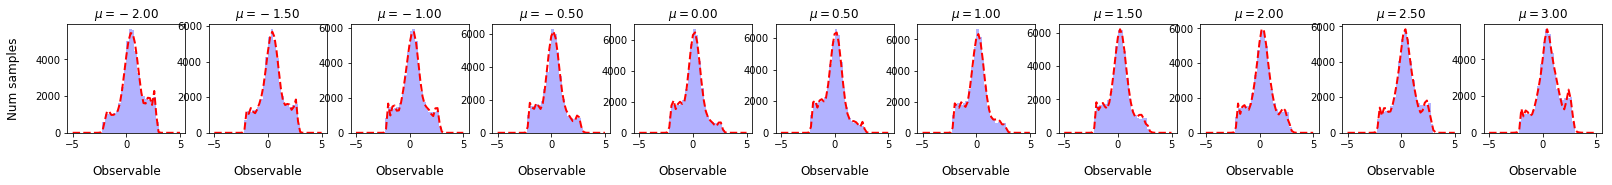

In [34]:

num_mu_scan_points = len(mu_scan_points)
fig = plt.figure(figsize=(2.5*num_mu_scan_points, 2))
ax_lims = axis_lims[0]
for ax_idx, mu in enumerate(mu_scan_points) :
    ax = fig.add_subplot(1, num_mu_scan_points, 1+ax_idx)
    plot_data  = white_datasets [mu][:,0]
    x = np.linspace(ax_lims[0], ax_lims[1], 51)
    ax.plot(x, len(plot_data)*density_model.evaluate(mu, x)*(ax_lims[1]-ax_lims[0])/41, c="red", linestyle="--", linewidth=2)
    ax.hist(plot_data, bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="blue", alpha=0.3)
    ax.set_xlabel("Observable", fontsize=12, labelpad=15)
    if ax_idx == 0 : ax.set_ylabel("Num samples", fontsize=12, labelpad=15)
    ax.set_title(f"$\mu = {mu:.2f}$")
plt.show()

In [35]:
density_model.fit(white_datasets, 
                  observable=[1, 2], 
                  max_epochs_per_observable=max_epochs,
                  early_stopping_patience=early_stopping_patience)

INFO       DensityModel.build          Queued the following observable indices to train: 1, 2
INFO       DensityModel.build          Parsing training data
INFO       DensityModel.build          Training observable index 1
INFO       DensityModel.build            -  Training setting: epochs = 1000
INFO       DensityModel.build            -  Training setting: batch_size = -1
INFO       DensityModel.build            -  Training setting: validation_split = 0.5
INFO       DensityModel.build            -  Training setting: early_stopping_patience = 100
INFO       DensityModel.build          Setting batch size to size of dataset, which is 550000
Train on 275000 samples, validate on 275000 samples
Epoch 1/1000
275000/275000 [==============================] - 3s 10us/step - loss: 2.5230 - val_loss: 2.4912
Epoch 2/1000
275000/275000 [==============================] - 1s 3us/step - loss: 2.4923 - val_loss: 2.4610
Epoch 3/1000
275000/275000 [==============================] - 1s 3us/step - loss: 2.

Epoch 70/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.2095 - val_loss: 1.2014
Epoch 71/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.2013 - val_loss: 1.1934
Epoch 72/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1933 - val_loss: 1.1856
Epoch 73/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1855 - val_loss: 1.1780
Epoch 74/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1780 - val_loss: 1.1707
Epoch 75/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1706 - val_loss: 1.1635
Epoch 76/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1635 - val_loss: 1.1565
Epoch 77/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1565 - val_loss: 1.1497
Epoch 78/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.1498 - val_loss: 1.1431
Epoch 79/1000
27500

Epoch 145/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.9090 - val_loss: 0.9064
Epoch 146/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.9067 - val_loss: 0.9042
Epoch 147/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.9045 - val_loss: 0.9020
Epoch 148/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.9023 - val_loss: 0.8998
Epoch 149/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.9002 - val_loss: 0.8977
Epoch 150/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8980 - val_loss: 0.8955
Epoch 151/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8959 - val_loss: 0.8934
Epoch 152/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8939 - val_loss: 0.8914
Epoch 153/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8918 - val_loss: 0.8893
Epoch 154/

Epoch 220/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8091 - val_loss: 0.8082
Epoch 221/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8084 - val_loss: 0.8076
Epoch 222/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8077 - val_loss: 0.8069
Epoch 223/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8070 - val_loss: 0.8063
Epoch 224/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8063 - val_loss: 0.8056
Epoch 225/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8056 - val_loss: 0.8050
Epoch 226/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8050 - val_loss: 0.8044
Epoch 227/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8043 - val_loss: 0.8038
Epoch 228/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.8037 - val_loss: 0.8032
Epoch 229/

Epoch 295/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7762 - val_loss: 0.7765
Epoch 296/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7759 - val_loss: 0.7762
Epoch 297/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7756 - val_loss: 0.7759
Epoch 298/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7753 - val_loss: 0.7756
Epoch 299/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7751 - val_loss: 0.7754
Epoch 300/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7748 - val_loss: 0.7751
Epoch 301/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7745 - val_loss: 0.7748
Epoch 302/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7742 - val_loss: 0.7745
Epoch 303/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7739 - val_loss: 0.7742
Epoch 304/

Epoch 370/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7549 - val_loss: 0.7552
Epoch 371/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7546 - val_loss: 0.7549
Epoch 372/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7543 - val_loss: 0.7546
Epoch 373/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7540 - val_loss: 0.7543
Epoch 374/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7537 - val_loss: 0.7540
Epoch 375/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7534 - val_loss: 0.7538
Epoch 376/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7531 - val_loss: 0.7535
Epoch 377/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7528 - val_loss: 0.7532
Epoch 378/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7525 - val_loss: 0.7529
Epoch 379/

Epoch 445/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7356 - val_loss: 0.7365
Epoch 446/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7354 - val_loss: 0.7362
Epoch 447/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7351 - val_loss: 0.7360
Epoch 448/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7349 - val_loss: 0.7357
Epoch 449/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7346 - val_loss: 0.7355
Epoch 450/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7343 - val_loss: 0.7352
Epoch 451/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7341 - val_loss: 0.7350
Epoch 452/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7338 - val_loss: 0.7347
Epoch 453/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7336 - val_loss: 0.7345
Epoch 454/

Epoch 520/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7180 - val_loss: 0.7191
Epoch 521/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7177 - val_loss: 0.7189
Epoch 522/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7175 - val_loss: 0.7187
Epoch 523/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7173 - val_loss: 0.7185
Epoch 524/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7171 - val_loss: 0.7183
Epoch 525/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7169 - val_loss: 0.7181
Epoch 526/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7167 - val_loss: 0.7179
Epoch 527/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7165 - val_loss: 0.7177
Epoch 528/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7163 - val_loss: 0.7175
Epoch 529/

Epoch 595/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7051 - val_loss: 0.7067
Epoch 596/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7050 - val_loss: 0.7066
Epoch 597/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7049 - val_loss: 0.7064
Epoch 598/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7047 - val_loss: 0.7063
Epoch 599/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7046 - val_loss: 0.7062
Epoch 600/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7045 - val_loss: 0.7061
Epoch 601/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7043 - val_loss: 0.7059
Epoch 602/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7042 - val_loss: 0.7058
Epoch 603/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7041 - val_loss: 0.7057
Epoch 604/

Epoch 670/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6967 - val_loss: 0.6985
Epoch 671/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6966 - val_loss: 0.6984
Epoch 672/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6965 - val_loss: 0.6983
Epoch 673/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6964 - val_loss: 0.6982
Epoch 674/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6963 - val_loss: 0.6982
Epoch 675/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6962 - val_loss: 0.6981
Epoch 676/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6961 - val_loss: 0.6980
Epoch 677/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6960 - val_loss: 0.6979
Epoch 678/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6959 - val_loss: 0.6978
Epoch 679/

Epoch 745/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6895 - val_loss: 0.6916
Epoch 746/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6894 - val_loss: 0.6915
Epoch 747/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6893 - val_loss: 0.6914
Epoch 748/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6892 - val_loss: 0.6913
Epoch 749/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6891 - val_loss: 0.6912
Epoch 750/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6890 - val_loss: 0.6911
Epoch 751/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6889 - val_loss: 0.6910
Epoch 752/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6888 - val_loss: 0.6909
Epoch 753/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6887 - val_loss: 0.6907
Epoch 754/

Epoch 820/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6777 - val_loss: 0.6798
Epoch 821/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6775 - val_loss: 0.6796
Epoch 822/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6772 - val_loss: 0.6793
Epoch 823/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6769 - val_loss: 0.6791
Epoch 824/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6766 - val_loss: 0.6788
Epoch 825/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6764 - val_loss: 0.6785
Epoch 826/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6761 - val_loss: 0.6782
Epoch 827/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6758 - val_loss: 0.6779
Epoch 828/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6755 - val_loss: 0.6776
Epoch 829/

Epoch 895/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6620 - val_loss: 0.6643
Epoch 896/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6618 - val_loss: 0.6642
Epoch 897/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6617 - val_loss: 0.6641
Epoch 898/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6616 - val_loss: 0.6639
Epoch 899/1000
275000/275000 [==============================] - 1s 5us/step - loss: 0.6615 - val_loss: 0.6638
Epoch 900/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6613 - val_loss: 0.6637
Epoch 901/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6612 - val_loss: 0.6636
Epoch 902/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6611 - val_loss: 0.6635
Epoch 903/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6610 - val_loss: 0.6633
Epoch 904/

Epoch 970/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6544 - val_loss: 0.6569
Epoch 971/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6544 - val_loss: 0.6568
Epoch 972/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6543 - val_loss: 0.6568
Epoch 973/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6542 - val_loss: 0.6567
Epoch 974/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6542 - val_loss: 0.6566
Epoch 975/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6541 - val_loss: 0.6566
Epoch 976/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6541 - val_loss: 0.6566
Epoch 977/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6540 - val_loss: 0.6565
Epoch 978/1000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6540 - val_loss: 0.6565
Epoch 979/

Epoch 40/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9754 - val_loss: 1.9667
Epoch 41/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9655 - val_loss: 1.9569
Epoch 42/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9557 - val_loss: 1.9473
Epoch 43/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9460 - val_loss: 1.9377
Epoch 44/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9365 - val_loss: 1.9284
Epoch 45/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9271 - val_loss: 1.9192
Epoch 46/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9178 - val_loss: 1.9101
Epoch 47/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9087 - val_loss: 1.9011
Epoch 48/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.8997 - val_loss: 1.8922
Epoch 49/1000
27500

275000/275000 [==============================] - 1s 3us/step - loss: 1.4810 - val_loss: 1.4789
Epoch 116/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4778 - val_loss: 1.4758
Epoch 117/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4747 - val_loss: 1.4728
Epoch 118/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4716 - val_loss: 1.4698
Epoch 119/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4686 - val_loss: 1.4669
Epoch 120/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4657 - val_loss: 1.4641
Epoch 121/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4629 - val_loss: 1.4613
Epoch 122/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4601 - val_loss: 1.4586
Epoch 123/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4574 - val_loss: 1.4560
Epoch 124/1000
275000/275

Epoch 190/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3692 - val_loss: 1.3700
Epoch 191/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3687 - val_loss: 1.3695
Epoch 192/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3682 - val_loss: 1.3690
Epoch 193/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3677 - val_loss: 1.3686
Epoch 194/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3672 - val_loss: 1.3681
Epoch 195/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3667 - val_loss: 1.3677
Epoch 196/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3663 - val_loss: 1.3672
Epoch 197/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3658 - val_loss: 1.3668
Epoch 198/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3654 - val_loss: 1.3663
Epoch 199/

Epoch 265/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3482 - val_loss: 1.3492
Epoch 266/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3481 - val_loss: 1.3490
Epoch 267/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3479 - val_loss: 1.3489
Epoch 268/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3478 - val_loss: 1.3488
Epoch 269/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3477 - val_loss: 1.3486
Epoch 270/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3476 - val_loss: 1.3485
Epoch 271/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3475 - val_loss: 1.3484
Epoch 272/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3473 - val_loss: 1.3483
Epoch 273/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3472 - val_loss: 1.3482
Epoch 274/

Epoch 340/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3420 - val_loss: 1.3429
Epoch 341/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3419 - val_loss: 1.3428
Epoch 342/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3419 - val_loss: 1.3428
Epoch 343/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3418 - val_loss: 1.3427
Epoch 344/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3418 - val_loss: 1.3427
Epoch 345/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3417 - val_loss: 1.3426
Epoch 346/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3417 - val_loss: 1.3426
Epoch 347/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3416 - val_loss: 1.3425
Epoch 348/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3416 - val_loss: 1.3425
Epoch 349/

Epoch 415/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3392 - val_loss: 1.3400
Epoch 416/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3391 - val_loss: 1.3400
Epoch 417/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3391 - val_loss: 1.3400
Epoch 418/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3391 - val_loss: 1.3399
Epoch 419/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3390 - val_loss: 1.3399
Epoch 420/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3390 - val_loss: 1.3399
Epoch 421/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3390 - val_loss: 1.3398
Epoch 422/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3390 - val_loss: 1.3398
Epoch 423/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3389 - val_loss: 1.3398
Epoch 424/

Epoch 490/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3385
Epoch 491/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3384
Epoch 492/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3384
Epoch 493/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3384
Epoch 494/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3384
Epoch 495/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3384
Epoch 496/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3376 - val_loss: 1.3384
Epoch 497/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3375 - val_loss: 1.3384
Epoch 498/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3375 - val_loss: 1.3384
Epoch 499/

Epoch 565/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3370 - val_loss: 1.3378
Epoch 566/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3370 - val_loss: 1.3378
Epoch 567/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3370 - val_loss: 1.3378
Epoch 568/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3370 - val_loss: 1.3378
Epoch 569/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3369 - val_loss: 1.3378
Epoch 570/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3369 - val_loss: 1.3378
Epoch 571/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3369 - val_loss: 1.3378
Epoch 572/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3369 - val_loss: 1.3378
Epoch 573/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3369 - val_loss: 1.3378
Epoch 574/

Epoch 640/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 641/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 642/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 643/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 644/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 645/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 646/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 647/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 648/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3365 - val_loss: 1.3374
Epoch 649/

Epoch 715/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 716/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 717/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 718/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 719/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 720/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 721/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 722/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 723/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3362 - val_loss: 1.3371
Epoch 724/

Epoch 790/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 791/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 792/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 793/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 794/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 795/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 796/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 797/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 798/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3359 - val_loss: 1.3369
Epoch 799/

Epoch 865/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 866/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 867/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 868/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 869/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 870/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 871/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 872/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 873/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3357 - val_loss: 1.3367
Epoch 874/

Epoch 940/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 941/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 942/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 943/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 944/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 945/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 946/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 947/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3355 - val_loss: 1.3365
Epoch 948/1000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3354 - val_loss: 1.3365
Epoch 949/

In [44]:
fake_DS = {}

for mu in mu_scan_points :
    print(f"Getting fakes for mu = {mu:.2f}")
    start = time.time()
    fake_DS [mu] = density_model.sample(mu, n_fake_points_per_c_per_ds)
    end = time.time()
    print(f"{len(fake_DS [mu])} datapoints generated for mu = {mu:.2f} in {end-start:.1f}s")
    

Getting fakes for mu = -2.00
INFO       DensityModel.sample         Getting Gaussian parameters for 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling Gaussians for 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Getting Gaussian parameters for 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling Gaussians for 50000 datapoints, observable index is 2
50000 datapoints generated for mu = -2.00 in 12.0s
Getting fakes for mu = -1.50
INFO       DensityModel.sample         Getting Gaussian parameters for 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling Gaussians for 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Getting Gaussian parameters for 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling Gaussians for 50000 datapoints, observable index is 2
50000 datapoints generated for mu = -1.

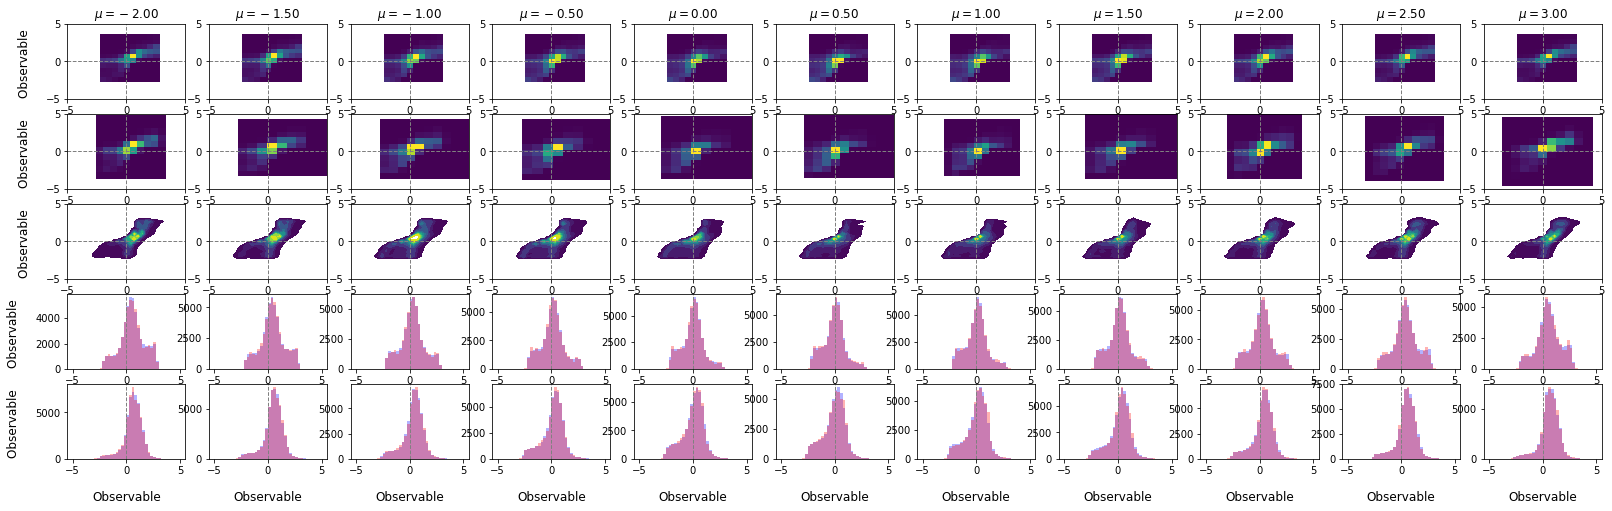

In [42]:

num_mu_scan_points = len(mu_scan_points)
fig = plt.figure(figsize=(2.5*num_mu_scan_points, 8))
ax_lims = axis_lims[0]
for ax_idx, mu in enumerate(mu_scan_points) :
    ax1 = fig.add_subplot(5, num_mu_scan_points, 1+ax_idx)
    n_sample_points = len(fake_DS [mu])
    plot_data  = white_datasets [mu][:n_sample_points]
    ax1.hist2d(plot_data[:,0], plot_data[:,1])
    ax1.axhline(0, linestyle="--", c="gray", linewidth=1.)
    ax1.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    ax2 = fig.add_subplot(5, num_mu_scan_points, num_mu_scan_points+1+ax_idx)
    plot_fakes = fake_DS [mu][:n_sample_points]
    ax2.hist2d(plot_fakes[:,0], plot_fakes[:,1])
    ax2.axhline(0, linestyle="--", c="gray", linewidth=1.)
    ax2.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    ax3 = fig.add_subplot(5, num_mu_scan_points, 2*num_mu_scan_points+1+ax_idx)
    x, y = np.linspace(ax_lims[0], ax_lims[1], 31), np.linspace(ax_lims[0], ax_lims[1], 31)
    x_grid, y_grid = np.meshgrid(x, y)
    z = np.zeros(shape=x_grid.shape)
    for i, xp in enumerate(x) :
        for j, yp in enumerate(y) :
            z [i, j] = density_model.evaluate(mu, xp, yp)
    z = z / np.max(z)
    ax3.contourf(x, y, z, levels=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ax3.axhline(0, linestyle="--", c="gray", linewidth=1.)
    ax3.axvline(0, linestyle="--", c="gray", linewidth=1.)
          
    ax1.set_xlim([ax_lims[0], ax_lims[1]])
    ax1.set_ylim([ax_lims[0], ax_lims[1]])
    ax2.set_xlim([ax_lims[0], ax_lims[1]])
    ax2.set_ylim([ax_lims[0], ax_lims[1]])
    ax3.set_xlim([ax_lims[0], ax_lims[1]])
    ax3.set_ylim([ax_lims[0], ax_lims[1]])
    
    ax4 = fig.add_subplot(5, num_mu_scan_points, 3*num_mu_scan_points+1+ax_idx)
    ax4.hist(plot_data [:,0], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="blue", alpha=0.3)
    ax4.hist(plot_fakes[:,0], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="red" , alpha=0.3)
    ax4.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    ax5 = fig.add_subplot(5, num_mu_scan_points, 4*num_mu_scan_points+1+ax_idx)
    ax5.hist(plot_data [:,1], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="blue", alpha=0.3)
    ax5.hist(plot_fakes[:,1], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="red" , alpha=0.3)
    ax5.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    ax5.set_xlabel("Observable", fontsize=12, labelpad=15)
    ax1.set_title(f"$\mu = {mu:.2f}$")
    if ax_idx == 0 : 
        ax1.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax2.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax3.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax4.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax5.set_ylabel("Observable ", fontsize=12, labelpad=15)
plt.show()

Plotting fake dataset


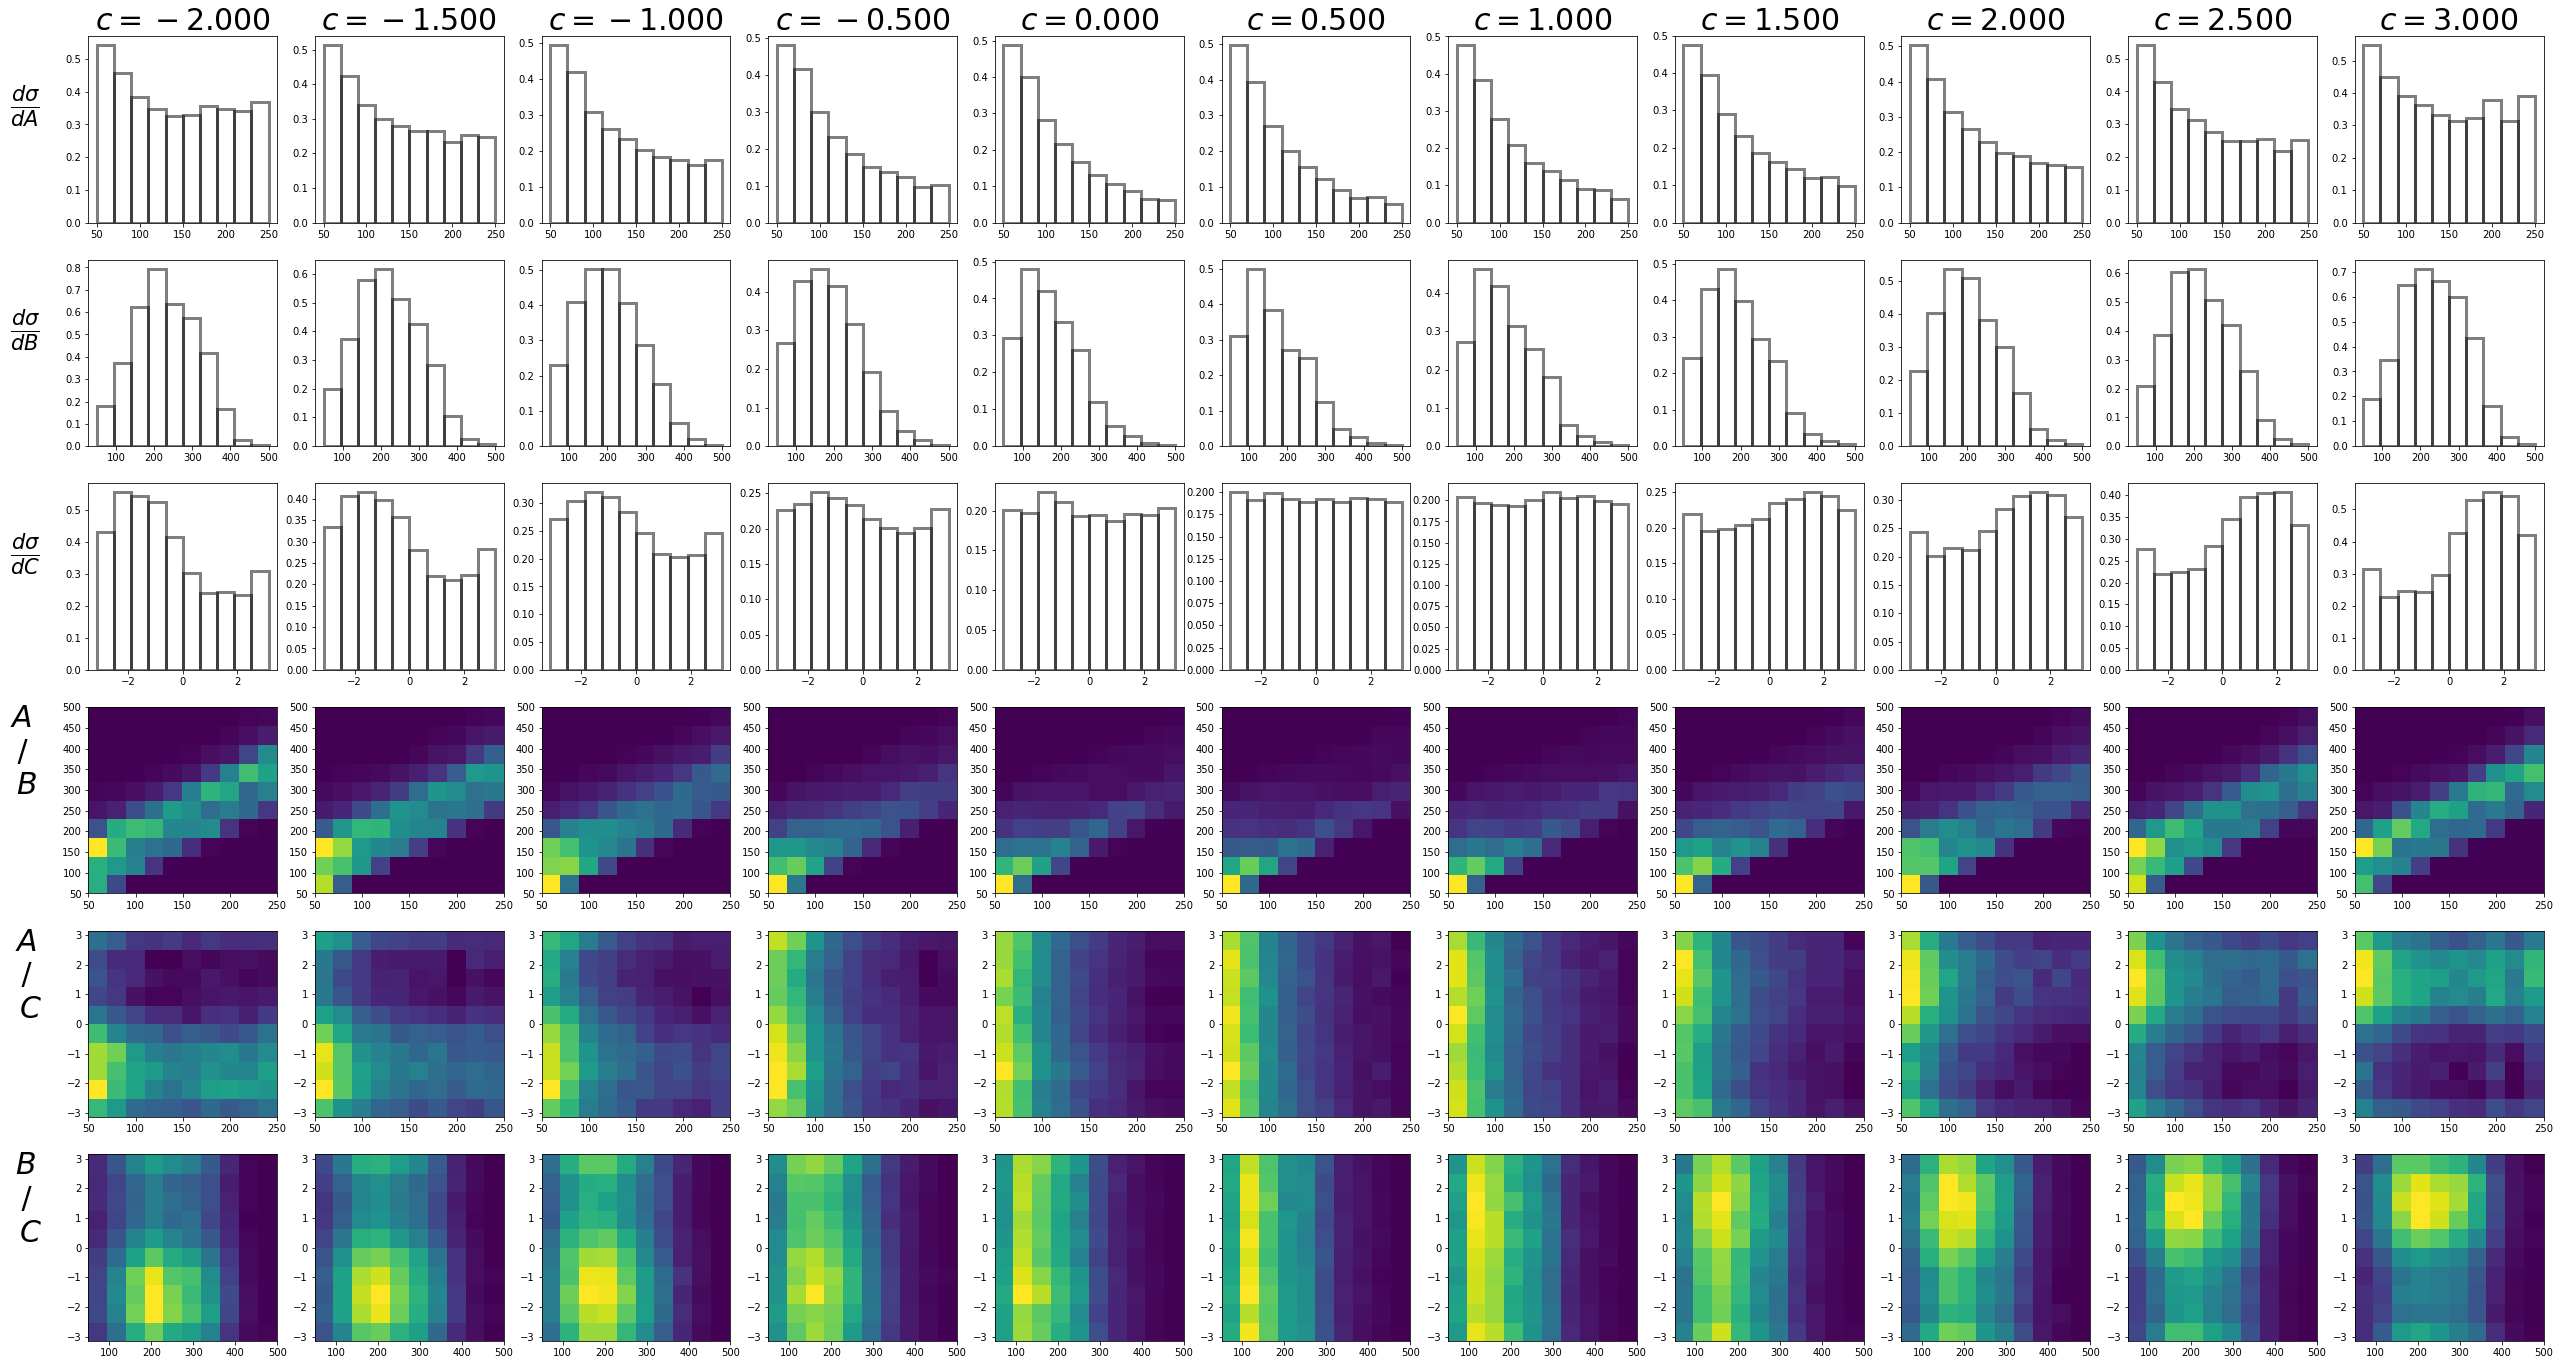

In [43]:
print("Plotting fake dataset")
fake_weights = {mu:np.full(fill_value=1./len(ds), shape=(len(ds),)) for mu,ds in fake_DS.items()}
plot_dataset(mu_scan_points, xsections, unwhiten_data(fake_DS), fake_weights)